In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_standard_weather.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df


,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,2.334143,25.7,96.0,12.9,7.5
2019-01-01 00:15:00,2.344050,25.7,96.0,12.9,7.5
2019-01-01 00:30:00,2.500311,25.7,96.0,12.9,7.5
2019-01-01 00:45:00,2.432096,25.7,96.0,12.9,7.5
2019-01-01 01:00:00,2.388465,25.7,96.0,12.9,7.5
...,...,...,...,...,...
2024-05-31 22:45:00,69.132420,29.8,68.0,0.0,10.8
2024-05-31 23:00:00,69.132420,29.8,68.0,0.0,10.8
2024-05-31 23:15:00,68.774401,29.8,68.0,0.0,10.8


In [3]:
scaler = StandardScaler()

In [4]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [5]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2019-01-01 00:00:00,-0.926090,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:15:00,-0.924906,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:30:00,-0.906232,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 00:45:00,-0.914384,-1.510370,2.072502,0.764111,-0.170246
2019-01-01 01:00:00,-0.919598,-1.510370,2.072502,0.764111,-0.170246
...,...,...,...,...,...
2022-12-31 22:45:00,-0.862522,0.644466,0.566106,2.975064,-2.743848
2022-12-31 23:00:00,-0.855322,0.644466,0.566106,2.975064,-2.743848
2022-12-31 23:15:00,-0.857181,0.644466,0.566106,2.975064,-2.743848


In [6]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,Tavg,RH_avg,RR,ss
READ_DATE,,,,,
2023-01-01 00:00:00,-0.851430,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:15:00,-0.845244,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:30:00,-0.848134,0.082335,0.797859,0.266869,-0.204561
2023-01-01 00:45:00,-0.871030,0.082335,0.797859,0.266869,-0.204561
2023-01-01 01:00:00,-0.842770,0.082335,0.797859,0.266869,-0.204561
...,...,...,...,...,...
2024-05-31 22:45:00,7.056613,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 23:00:00,7.056613,2.330858,-1.172043,-0.381322,0.962138
2024-05-31 23:15:00,7.013828,2.330858,-1.172043,-0.381322,0.962138


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(140160, 96, 5) (140160,)
(49536, 96, 5) (49536,)


In [9]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 96, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 0.0462 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 2/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.0149 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 3/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.0142 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0141 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 5/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0138 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 6/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0136 - val_loss: 0.0092 - learning_rate: 9.0484e-04
Epoch 7/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 0.0132 - val_loss: 0.0083 - learning_rate: 8.1873e-04
Epoch 8/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0130 - val_loss: 0.0086 - learning_rate: 7.4082e-04
Epoch 9/100
3942/3942 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.0130 -

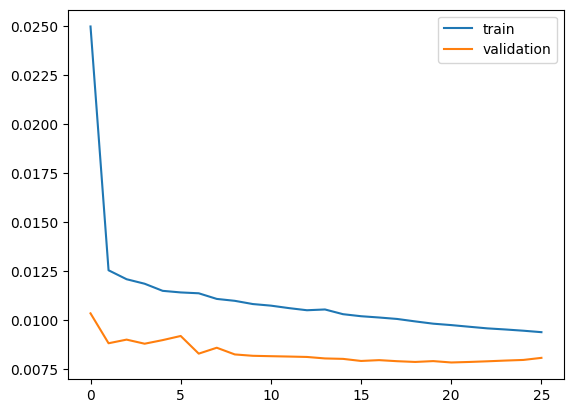

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [14]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


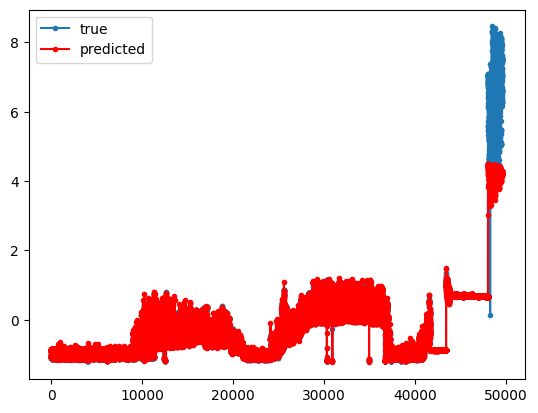

In [15]:
plt.plot(y_test, marker='.', label='true')
plt.plot(y_pred, 'r', marker='.', label='predicted')
plt.legend()
plt.show()

In [16]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.17560112087530186
MAE: 0.09609484761647928
R2: 0.902332465168866
MAPE: 0.38545860981424174
